In [1]:
import sklearn.preprocessing as pre, scipy, numpy as np, matplotlib.pyplot as plt, glob, sys, os
import pandas as pd, seaborn as sns, argparse, pyemma as py, pickle, copy
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from hde import HDE, analysis

sys.path.insert(1, '../msms/')
from utils import * 

Using TensorFlow backend.


In [2]:
tstep = 100 #ps

# leave out first skip frames
max_frames = 100000
max_trajs = 25
max_epochs = 3  # for traininng SRVs
n_folds = 5

lag = 10 # converged for srv, tica not quite
seq_list = ['TATAGCGATAT', 'CGCATATATAT', 'CCTATATATCC', 'TTTTTTTTTTT']

# add kfolds and more epochs

In [3]:
cluster_stride = 100
n_clustercenters = 200
nits, its_lags = 5, 100
run = False

if run:
    df = pd.DataFrame(columns=['seq', 'base', 'dim', 'its', 'train_score', 'test_score'])
    
    for seq in seq_list:
        base_list = [base for base in abasic_configs[seq].keys()]
        for base in base_list:

            # combine first and second run
            npy_name = glob.glob(f'../abasic_dists/{seq}_msm_add-Tms/{base}*')[0]
            dists = np.load(npy_name)[:max_trajs, -max_frames:, :]

            # fit SRV
            SRV = fit_SRV([1/d for d in dists], 6, max_epochs, lag)
            srv_basis = [SRV.transform(1/d) for d in dists]
            print(SRV.timescales_)

            for dim in range(2, 7):
                print(seq, base, dim)

                # cluster and build msm
                cluster = py.coordinates.cluster_kmeans([b[:, :dim] for b in srv_basis], 
                            stride=cluster_stride, k=n_clustercenters, max_iter=50)
                dtraj = cluster.dtrajs

                # plot implied timescale
                _, ax = plt.subplots(figsize=(5, 5))
                its = py.msm.its(dtraj, lags=50, nits=5)
                py.plots.plot_implied_timescales(its, ax=ax)
                ax.set_title(f'{seq}_{base}_{dim}')

                # perform n_folds cross val
                train_list, test_list = [], []
                all_idxs = list(np.arange(len(dtraj)))
                remaining_idxs = list(np.arange(len(dtraj)))

                for _ in range(n_folds):
                    test_idxs = np.random.choice(remaining_idxs, size=5, replace=False)
                    train_idxs = list(set(all_idxs) - set(test_idxs))
                    remaining_idxs = list(set(remaining_idxs) - set(test_idxs))
                    print(test_idxs)

                    msm = py.msm.bayesian_markov_model([dtraj[i] for i in train_idxs], lag=lag)
                    train_score = msm.score([dtraj[i] for i in train_idxs])
                    test_score = msm.score([dtraj[i] for i in test_idxs])

                    train_list.append(train_score)
                    test_list.append(test_score)

                train_score, train_std = np.mean(train_list), np.std(train_list)
                test_score, test_std = np.mean(test_list), np.std(test_list)

                its = msm.timescales(3)
                df = df.append({'seq':seq, 'base':base, 'dim':dim, 'its':its, 
                           'train_score':train_score, 'test_score':test_score,
                           'train_std':train_std, 'test_std':test_std}, ignore_index=True)

                print(base, its, np.round(train_score, 2), np.round(test_score, 2))   

                #break
            #break
        #break

    pickle.dump(df, open('df_cross_validate_srvs.pkl', 'wb'))

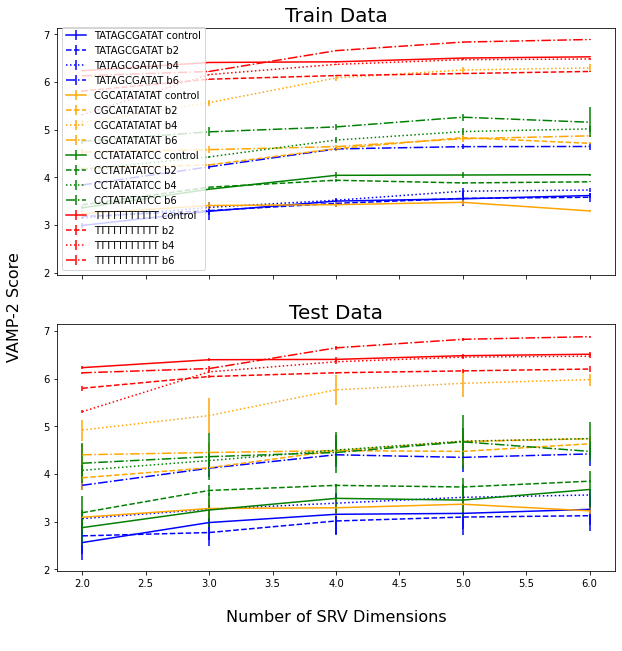

In [4]:
df = pickle.load(open('df_cross_validate_srvs.pkl', 'rb'))

afont = {'fontname':'Helvetica', 'fontsize':20}
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True, sharey=True)
c_list = ['blue', 'orange', 'green', 'red']
s_list = ['solid', 'dashed', 'dotted', 'dashdot']

for seq, c in zip(seq_list, c_list):
    base_list = [base for base in abasic_configs[seq].keys()]
    for base, s in zip(base_list, s_list):

        df_plot = df.loc[lambda df: (df['seq'] == seq) & (df['base'] == base), :]
        label = f'{seq} {base}'
        
        axes[0].errorbar(df_plot['dim'], df_plot['train_score'], yerr=df_plot['train_std'],
                          c=c, capsize=None, alpha=1, label=label, linestyle=s)
        axes[1].errorbar(df_plot['dim'], df_plot['test_score'], yerr=df_plot['test_std'],
                          c=c, capsize=None, alpha=1, label=label, linestyle=s)
    
axes[0].legend(loc='lower left')
axes[0].set_title('Train Data', fontsize=20)
axes[1].set_title('Test Data', fontsize=20)
spaces = ' '*55
axes[1].set_ylabel(f'{spaces}VAMP-2 Score\n', fontsize=16)
axes[1].set_xlabel('\nNumber of SRV Dimensions', fontsize=16)

plt.savefig('./figs/all_SRV_train_test.pdf', dpi=600)
plt.savefig('./figs/all_SRV_train_test.png', dpi=600)

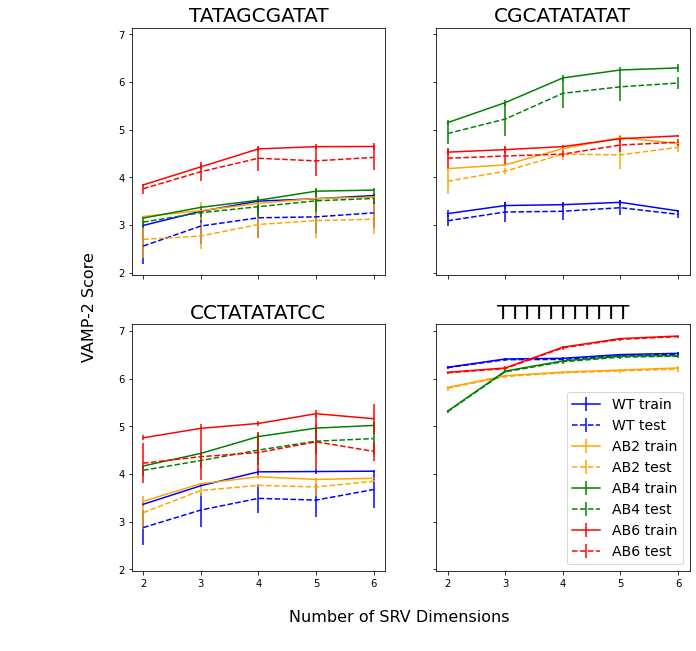

In [5]:
# use a 2x2 representation with axes for eaach sequenceinstead
df = pickle.load(open('df_cross_validate_srvs.pkl', 'rb'))

afont = {'fontname':'Helvetica', 'fontsize':20}
c_list = ['blue', 'orange', 'green', 'red']
s_list = ['solid', 'dashed', 'dotted', 'dashdot']
leg_dict = {'control':'WT', 'b2':'AB2', 'b4':'AB4', 'b6':'AB6'}

fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for seq, ax in zip(seq_list, axes.flatten()):
    base_list = [base for base in abasic_configs[seq].keys()]
    for base, c in zip(base_list, c_list):

        df_plot = df.loc[lambda df: (df['seq'] == seq) & (df['base'] == base), :]
        
        ax.errorbar(df_plot['dim'], df_plot['train_score'], yerr=df_plot['train_std'],
                          c=c, capsize=None, alpha=1, label=f'{leg_dict[base]} train', linestyle='solid')
        
        ax.errorbar(df_plot['dim'], df_plot['test_score'], yerr=df_plot['test_std'],
                          c=c, capsize=None, alpha=1, label=f'{leg_dict[base]} test', linestyle='dashed')
        
    ax.set_title(seq, fontsize=20)
    
spaces = ' '*55
ax.legend(loc='lower right', fontsize=14)
axes[1, 0].set_ylabel(f'{spaces}VAMP-2 Score\n', fontsize=16)
axes[1, 0].set_xlabel(f'\n{spaces}Number of SRV Dimensions', fontsize=16)

#plt.savefig('./figs/all_SRV_train_test.pdf', dpi=600)
#plt.savefig('./figs/all_SRV_train_test.png', dpi=600)

# save as svg
plt.savefig('./figs/all_SRV_train_test.svg', format='svg', bbox_inches='tight', transparent=True, dpi=600)

W0301 08:39:16.454566 139872055392064 deprecation_wrapper.py:119] From /home/mikejones/scratch-midway2/conda_envs/srv_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0301 08:39:16.478115 139872055392064 deprecation_wrapper.py:119] From /home/mikejones/scratch-midway2/conda_envs/srv_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0301 08:39:16.579429 139872055392064 deprecation_wrapper.py:119] From /home/mikejones/scratch-midway2/conda_envs/srv_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0301 08:39:16.580300 139872055392064 deprecation_wrapper.py:119] From /home/mikejones/scratch-midway2/conda_envs/srv_env/lib/python3.7/site-packages/keras/backend

(25, 100000)


(25, 100000)


(25, 100000)


(25, 100000)


(25, 100000)


(25, 100000)


(25, 100000)


(25, 100000)


(25, 100000)


(25, 100000)


(25, 100000)


(25, 100000)


(25, 100000)


(25, 100000)


(25, 100000)


(25, 100000)


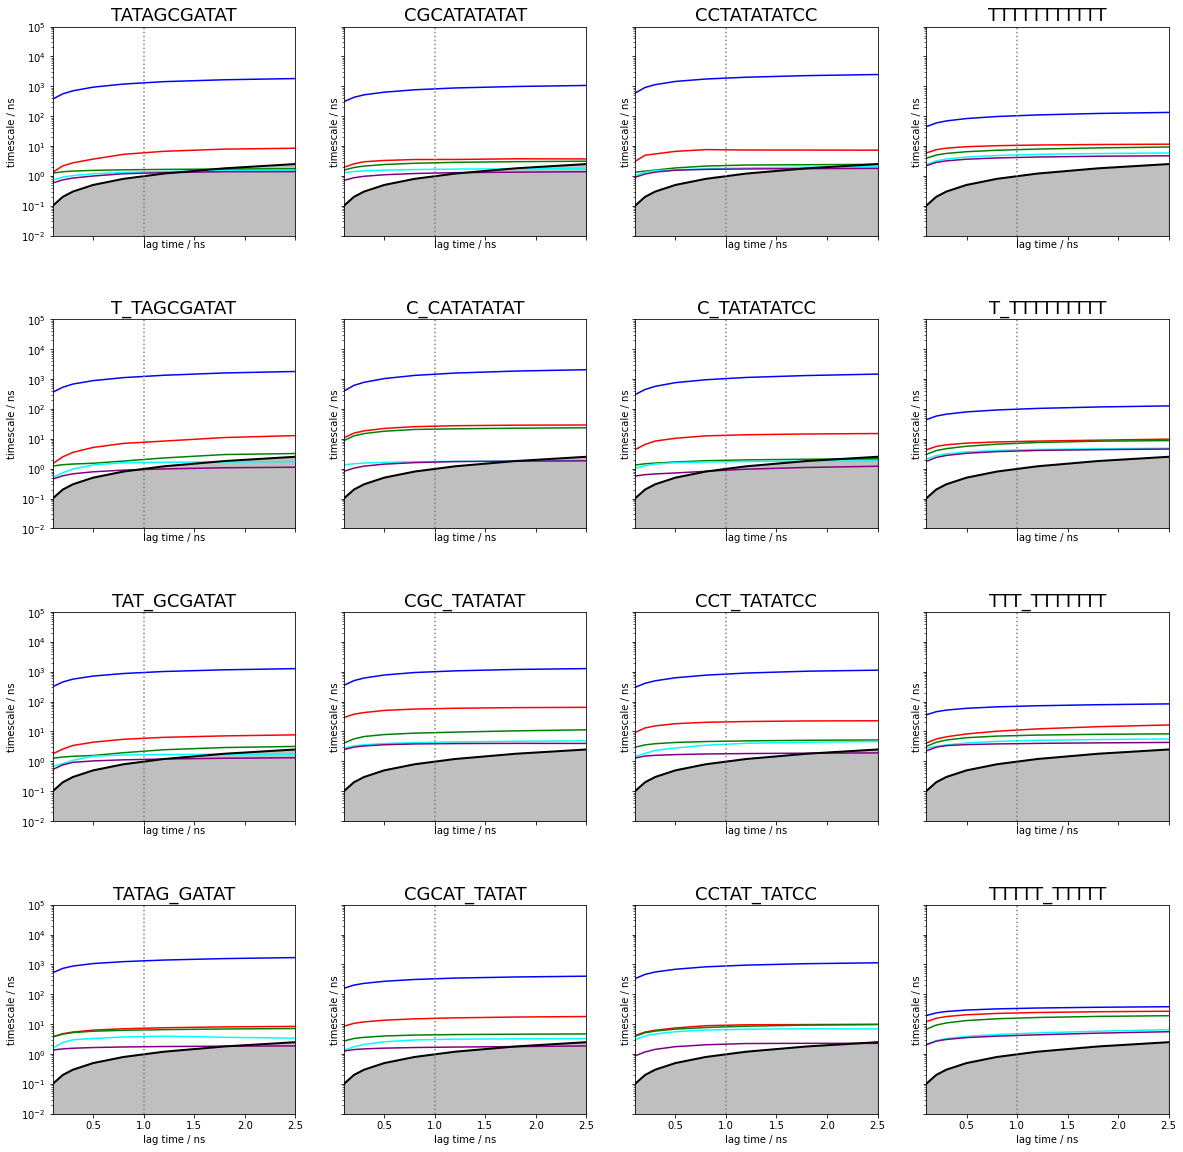

In [6]:
# plot timescales convergence for each msm

fig, axes = plt.subplots(4, 4, figsize=(20, 20), sharex=True, sharey=True)
for seq, ax_row in zip(seq_list, axes.T):
    
    bidxs = [0, 2, 4, 6]
    base_list = [base for base in abasic_configs[seq].keys()]
    save_name = f'./save_outputs/{seq}_lag-{lag}_dict'
    save_dict = pickle.load(open(save_name, 'rb'))
    dtraj_list = save_dict['dtraj_list']
    msm_list = save_dict['msm_list']
    
    for base, bidx, dtraj, msm, ax in zip(base_list, bidxs, dtraj_list, msm_list, ax_row):
    #for base, bidx, dtraj, cluster, commitor, srv_coords in zip(base_list, base_idxs, dtraj_list, cluster_list, commitor_list, srv_list):
        
        # calculate and plot its
        dtraj = [d for d in dtraj.reshape((25, 100000))]
        print(np.shape(dtraj))
        
        its = py.msm.its(dtraj, lags=25, nits=5)
        py.plots.plot_implied_timescales(its, ax=ax, dt=0.1, units='ns')

        # cks test
        #py.plots.plot_cktest(msm.cktest(3))
        
        if base=='control': abasic_label= seq
        else:       abasic_label= f'{seq[:bidx-1]}_{seq[bidx:]}'
        ax.set_title(abasic_label, fontsize=18)
        ax.axvline(lag/10, linestyle='dotted', color='gray')
        ax.set_ylim(0.01, 100000)
        
        #break
    #break
    
plt.subplots_adjust(hspace=0.4)

#plt.savefig('./figs/all_SRV_its.pdf', dpi=600)
#plt.savefig('./figs/all_SRV_its.png', dpi=600)
    
# save as svg
plt.savefig('./figs/all_SRV_its.svg', format='svg', bbox_inches='tight', transparent=True, dpi=600)

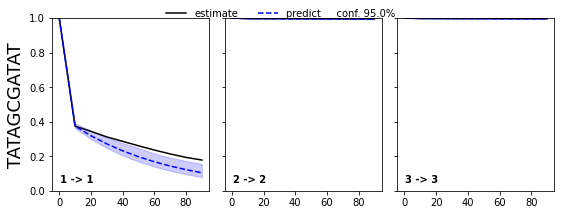

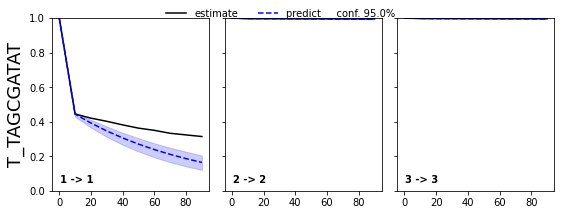

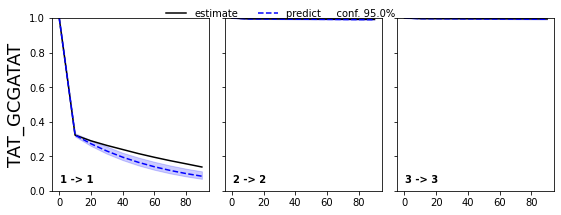

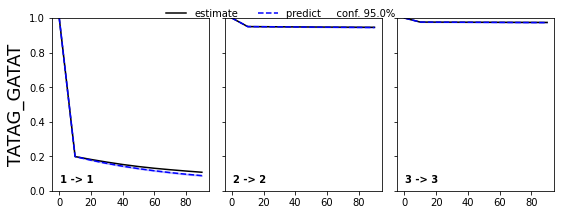

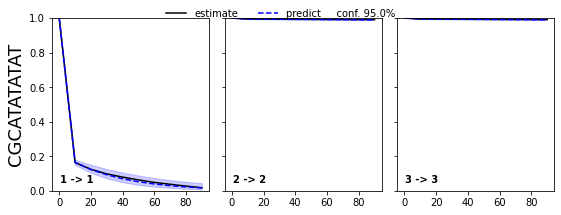

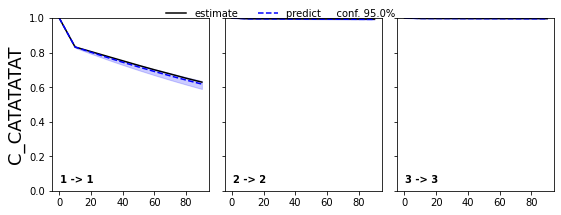

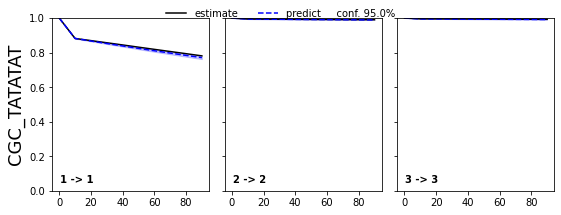

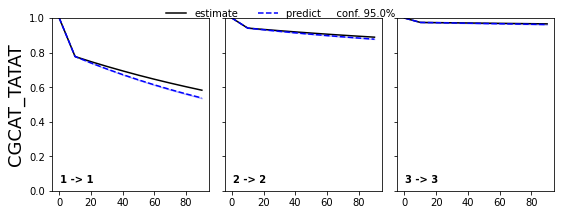

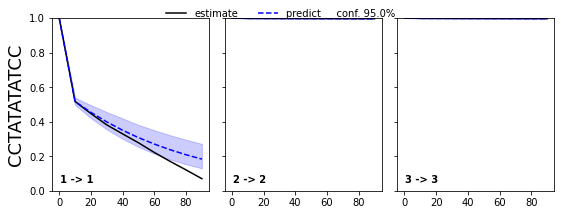

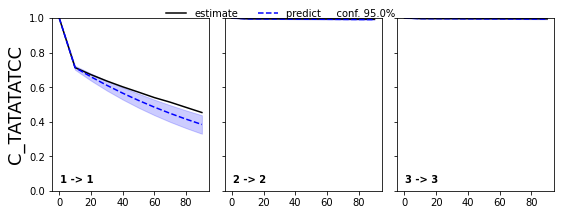

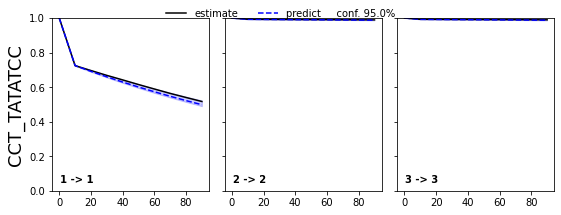

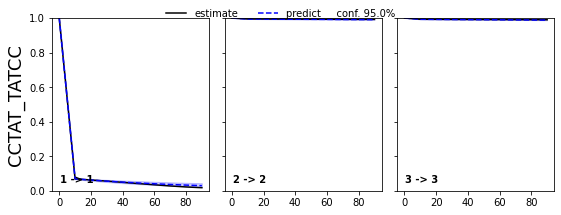

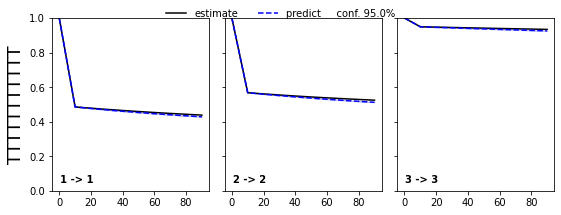

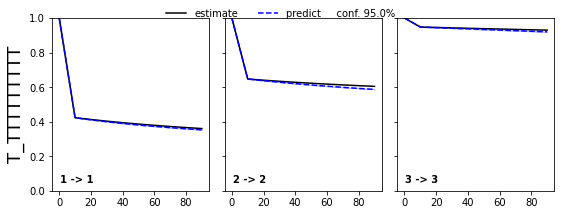

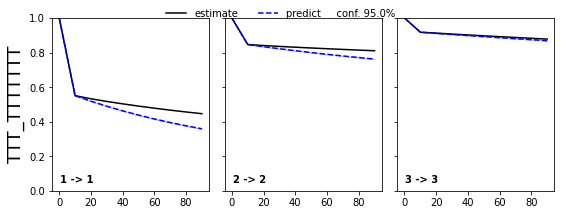

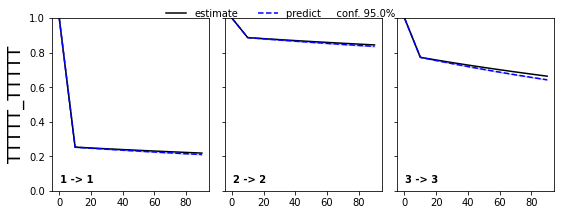

In [7]:
# plot ck test convergence for each msm

#fig, axes = plt.subplots(4, 4, figsize=(20, 20), sharex=True, sharey=True)
for seq in seq_list:
    
    bidxs = [0, 2, 4, 6]
    base_list = [base for base in abasic_configs[seq].keys()]
    save_name = f'./save_outputs/{seq}_lag-{lag}_dict'
    save_dict = pickle.load(open(save_name, 'rb'))
    dtraj_list = save_dict['dtraj_list']
    msm_list = save_dict['msm_list']
    
    for base, bidx, dtraj, msm in zip(base_list, bidxs, dtraj_list, msm_list):
    #for base, bidx, dtraj, cluster, commitor, srv_coords in zip(base_list, base_idxs, dtraj_list, cluster_list, commitor_list, srv_list):

        # cks test on pre-trained msm
        fig, axes = py.plots.plot_cktest(msm.cktest(3), layout='wide', diag=True)
        
        if base=='control': abasic_label= seq
        else:       abasic_label= f'{seq[:bidx-1]}_{seq[bidx:]}'
        axes[0].set_ylabel(abasic_label, fontsize=18)
        
        #save svg
        plt.savefig(f'./figs/all_SRV_ck_{seq}_{bidx}.svg', format='svg', bbox_inches='tight', transparent=True, dpi=600)
    
plt.subplots_adjust(hspace=0.4)
